In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import cv2
import sys
import time
import math
import random
import pandas as pd

from sklearn.metrics import confusion_matrix
from datetime import timedelta

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

In [3]:
# Convolutional Layer 1
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 64

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
# one-hot encoding - has_ellipse, no_ellipse
ellipse = [1, 0]
empty   = [0, 1]
classes = [ellipse, empty]
num_classes = len(classes)

shape_output_size = 5

# batch size
batch_size = 32

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

In [4]:
#Read one-hot encoding of labels
#[1,0] indicates has ellipse
#[0,1] indidates no ellipse

def get_labels(set, skip=0, count=2**31):
    skipped = 0
    counted = 0
    index = -1
    labels = []
    for filename in os.listdir(set):
        index += 1
        if(skipped < skip):
            skipped += 1
        else:
            if ('_T_' in filename):
                labels.append(ellipse)
            else:
                labels.append(empty)
            counted += 1
            if(counted >= count):
                break;

    labels = np.array(labels)
    return labels

In [5]:
train_labels = get_labels('train')
test_labels = get_labels('test')
validation_labels = get_labels('validation')

In [6]:
#Read (x_center, y_center), (major_axis, minor_axis) and (angle) from the filename

def get_shapes(set, skip=0, count=2**31):
    skipped = 0
    counted = 0
    index = -1

    shapes = []
    for filename in os.listdir(set):
        index += 1
        if(skipped < skip):
            skipped += 1
        else:
            x_center = 0
            y_center = 0
            major_axis = 0
            minor_axis = 0 
            angle = 0
            if ('_T_' in filename):
                filename = filename.replace('.png', '')
                shape = filename.split('_')
                shape = shape[3:]
                shape = [int(i) for i in shape]
                
                x_center   = shape[0]
                y_center   = shape[1]
                major_axis = shape[2]
                minor_axis = shape[3]
                angle      = shape[4]
            else:
                x_center   = 0
                y_center   = 0
                major_axis = 0
                minor_axis = 0
                angle      = 0

            #Normalize
                
            #x_center is between 8 and 56
            x_center -= (8+56)/2
            x_center /= (56-8)/2

            #x_center is between 8 and 56   
            y_center -= (8+56)/2
            y_center /= (56-8)/2            
                
            #major_axis is beteen 5 and 32
            major_axis -= (5+32)/2
            major_axis /= (32-5)/2
                
            #major_axis is beteen 5 and 32
            minor_axis -= (5+32)/2
            minor_axis /= (32-5)/2
                
            #angle is between 0 and 360
            angle -= (0+360)/2
            angle /= (360-0)/2
                
            shapes.append([x_center, y_center, major_axis, minor_axis, angle])
                
            counted += 1
            
            if(counted >= count):
                break;

    shapes = np.array(shapes)
    return shapes

In [7]:
train_shapes = get_shapes('train')
test_shapes = get_shapes('test')
validation_shapes = get_shapes('validation')

In [8]:
#Read a single image
def get_image(set, filename):
    return cv2.imread(set+'/'+filename)

#Read the whole images of a set
def get_images(set, skip=0, count=2**31):
    skipped = 0
    counted = 0
    index = -1
    images = []
    for filename in os.listdir(set):
        index += 1
        if(skipped < skip):
            skipped += 1
        else:
            img = get_image(set, filename)
            images.append(img)
            counted += 1
            if(counted>=count):
                break;

    images = np.array(images)
    return images

In [9]:
test_images = get_images('test')    
train_images = get_images('train')
validation_images = get_images('validation')

In [10]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(train_labels)))
print("- Test-set:\t\t{}".format(len(test_labels)))
print("- Validation-set:\t{}".format(len(validation_labels)))

Size of:
- Training-set:		50000
- Test-set:		10000
- Validation-set:	10000


In [11]:
def plot_images(images, cls_true, cls_pred=None):
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

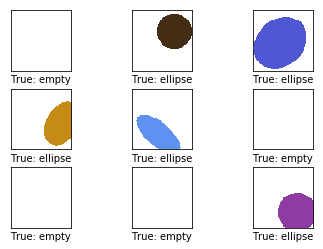

In [12]:
# Get some random images and their labels from the train set.

images, cls_true = train_images, train_labels

# Plot the images and labels using our helper-function above.

pretty_cls_true = []
for x in range(cls_true.shape[0]):
    if np.array_equal(cls_true[x], ellipse):
        pretty_cls_true.append('ellipse')
    else:
        pretty_cls_true.append('empty')        

plot_images(images=images, cls_true=pretty_cls_true)

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [14]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [15]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [16]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [17]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [18]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [19]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [20]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [21]:
y_shape_true = tf.placeholder(tf.float32, shape=[None, shape_output_size], name='y_shape_true')

In [22]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [23]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [24]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 32) dtype=float32>

In [25]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [26]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 32) dtype=float32>

In [27]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [28]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 8, 8, 64) dtype=float32>

In [29]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [30]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 4096) dtype=float32>

In [31]:
num_features

4096

In [32]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [33]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [34]:
layer_fc2_1 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [35]:
layer_fc2_1

<tf.Tensor 'add_4:0' shape=(?, 2) dtype=float32>

In [36]:
y_pred = tf.nn.softmax(layer_fc2_1)

In [37]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [38]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2_1,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [39]:
cost_type = tf.reduce_mean(cross_entropy)

In [40]:
layer_fc2_2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=shape_output_size,
                         use_relu=False)

In [41]:
layer_fc2_2

<tf.Tensor 'add_5:0' shape=(?, 5) dtype=float32>

In [42]:
cost_shape = tf.reduce_mean(tf.squared_difference(layer_fc2_2, y_shape_true))

In [43]:
total_cost = tf.add(cost_type, cost_shape)

In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(total_cost)

In [45]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [46]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [47]:
session = tf.Session()

In [48]:
session.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [49]:
train_batch_size = batch_size

In [50]:
batch_index_train = 0
batch_index_test = 0
batch_index_validation = 0

#Return the next batch of X, Y-labels and Y-shape-numbers
def next_batch(set, train_batch_size):
    global batch_index_train
    global batch_index_test
    global batch_index_validation
    
    batch_index = 0
    if (set == 'train'):
        batch_index = batch_index_train
        batch_index_train += train_batch_size
    if (set == 'test'):
        batch_index = batch_index_test
        batch_index_test += train_batch_size
    if (set == 'train'):
        batch_index = batch_index_validation
        batch_index_validation += train_batch_size
    
    #Not the most elegant way to normalize... should fix
    x_batch = get_images(set, skip=batch_index, count=train_batch_size)
    x_batch = x_batch.astype(float)
    x_batch -= (0+256)/2
    x_batch /= (256-0)/2
    y_true_batch = get_labels(set, skip=batch_index, count=train_batch_size)
    y_shape_true_batch = get_shapes(set, skip=batch_index, count=train_batch_size)
    if (x_batch.shape[0] < train_batch_size):
        print('Rolling...')
        batch_index = 0;
        return next_batch(set, train_batch_size)
    
    batch_index += train_batch_size
    return x_batch, y_true_batch, y_shape_true_batch

In [51]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, y_shape_true_batch = next_batch('train', train_batch_size)
        x_valid_batch, y_valid_batch, y_valid_shape_batch = next_batch('validation', train_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           y_shape_true: y_shape_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch,
                              y_shape_true: y_valid_shape_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        _, tot_loss, type_loss, shape_loss = session.run([optimizer, total_cost, cost_type, cost_shape], feed_dict=feed_dict_train)
        msg = "Training - Total Loss: {0:.3f}, Type Loss: {1:.3f}, Shape Loss: {2:.3f}"
        print(msg.format(tot_loss, type_loss, shape_loss))
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(train_images.shape[0]/batch_size) == 0: 
            val_loss = session.run(total_cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(train_images.shape[0]/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [52]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc, acc_shape = session.run([accuracy, cost_shape], feed_dict=feed_dict_train)
    val_acc, val_acc_shape = session.run([accuracy, cost_shape], feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))
    msg = "Epoch {0} --- Training Shape Accuracy: {1:.3f}, Validation Shape Accuracy: {2:.3f}"
    print(msg.format(epoch + 1, acc_shape, val_acc_shape))

In [53]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = np.logical_not(correct)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = validation_images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    
    # Get the true classes for those images.
    cls_true = validation_labels[incorrect]
    
    pretty_cls_true = []
    for x in range(cls_true.shape[0]):
        if np.array_equal(cls_true[x], ellipse):
            pretty_cls_true.append('ellipse')
        else:
            pretty_cls_true.append('empty')        

    pretty_pred_true = []
    for x in range(cls_pred.shape[0]):
        if np.array_equal(cls_pred[x], ellipse):
            pretty_pred_true.append('ellipse')
        else:
            pretty_pred_true.append('empty')        

    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=pretty_cls_true[0:9],
                cls_pred=pretty_pred_true[0:9])

In [54]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = validation_labels

    cls_true = [np.where(r==1)[0][0] for r in cls_true]
    cls_pred = [np.where(r==1)[0][0] for r in cls_pred]
    
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [55]:
def print_validation_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = validation_images.shape[0]

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    shape_pred = np.zeros(shape=(num_test, 5))

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i+batch_size < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = validation_images[i:j, :].reshape(batch_size, img_size_flat)
        images = images.astype(float)
        images -= (0+256)/2
        images /= (256-0)/2        

        # Get the associated labels.
        labels = validation_labels[i:j, :]
        
        shapes = validation_shapes[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels,
                     y_shape_true: shapes}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j], shape_pred[i:j] = session.run([y_pred_cls, layer_fc2_2], feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(validation_labels)
    shape_true = np.array(validation_shapes)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    correct_sum = 0;
    #correct = (cls_true == cls_pred)
    correct = []
    sum_squares = 0
    for i in range(cls_pred.shape[0]):        
        correct_sum += cls_true[i][0] == cls_pred[i][0]
        correct.append(cls_true[i][0] == cls_pred[i][0])
        sum_squares += sum(map(lambda x:x*x, shape_true[i] - shape_pred[i]))
    
    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    msg = "Error of shape detection on Test-Set: {0:.2}"
    print(msg.format(math.sqrt(sum_squares/num_test)))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Total Loss: 2.058, Type Loss: 0.719, Shape Loss: 1.339
Epoch 1 --- Training Accuracy:  37.5%, Validation Accuracy:  50.0%, Validation Loss: 1.760
Epoch 1 --- Training Shape Accuracy: 1.255, Validation Shape Accuracy: 1.072
Time elapsed: 0:00:01
Accuracy on Test-Set: 50.4% (5043 / 10000)
Error of shape detection on Test-Set: 2.3
Example errors:


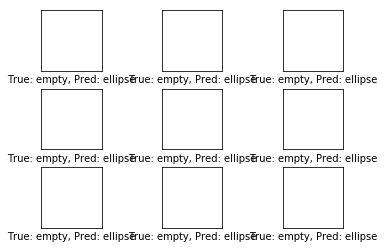

Confusion Matrix:
[[5043    0]
 [4957    0]]


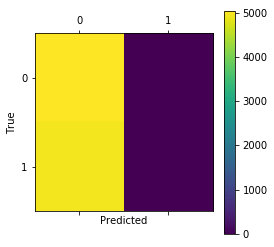

In [56]:
optimize(num_iterations=1)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [57]:
def print_test_accuracy(i):
    images = test_images[i, :].reshape(1, img_size_flat)
    images = images.astype(float)
    images -= (0+256)/2
    images /= (256-0)/2
    print(test_images.shape)
    print(images.shape)

    # Get the associated labels.
    labels = test_labels[i, :].reshape(1, num_classes)
    print(test_labels.shape)
    print(labels.shape)
        
    shapes = test_shapes[i, :].reshape(1, shape_output_size)
    print(test_shapes.shape)
    print(shapes.shape)

    # Create a feed-dict with these images and labels.
    feed_dict = {x: images,
                 y_true: labels,   
                 y_shape_true: shapes}

    # Calculate the predicted class using TensorFlow.
    cls_pred, shape_pred = session.run([y_pred_cls, layer_fc2_2], feed_dict=feed_dict)
    print()

    #Reverting back after normlization...
    #Ugly duplicated code... should be fixed
    shape_pred[0][0] *= (56-8)/2
    shape_pred[0][0] += (56-8)/2
    shape_pred[0][0] = int(round(shape_pred[0][0]))

    shape_pred[0][1] *= (56-8)/2
    shape_pred[0][1] += (56-8)/2
    shape_pred[0][1] = int(round(shape_pred[0][1]))
    
    shape_pred[0][2] *= (32-5)/2
    shape_pred[0][2] += (5+32)/2
    shape_pred[0][2] = int(round(shape_pred[0][2]))
    
    shape_pred[0][3] *= (32-5)/2
    shape_pred[0][3] += (5+32)/2
    shape_pred[0][3] = int(round(shape_pred[0][3]))

    shape_pred[0][4] *= (360-0)/2
    shape_pred[0][4] += (0+360)/2
    shape_pred[0][4] = int(round(shape_pred[0][4]))

    
    shapes[0][0] *= (56-8)/2
    shapes[0][0] += (56-8)/2
    shapes[0][0] = int(round(shapes[0][0]))

    shapes[0][1] *= (56-8)/2
    shapes[0][1] += (56-8)/2
    shapes[0][1] = int(round(shapes[0][1]))
    
    shapes[0][2] *= (32-5)/2
    shapes[0][2] += (5+32)/2
    shapes[0][2] = int(round(shapes[0][2]))
    
    shapes[0][3] *= (32-5)/2
    shapes[0][3] += (5+32)/2
    shapes[0][3] = int(round(shapes[0][3]))

    shapes[0][4] *= (360-0)/2
    shapes[0][4] += (0+360)/2
    shapes[0][4] = int(round(shapes[0][4]))
    
    print(shape_pred)
    print(shapes)



Total Loss: 2.076, Type Loss: 0.724, Shape Loss: 1.352
Total Loss: 1.945, Type Loss: 0.709, Shape Loss: 1.236
Total Loss: 1.536, Type Loss: 0.675, Shape Loss: 0.860
Total Loss: 1.646, Type Loss: 0.692, Shape Loss: 0.954
Total Loss: 1.342, Type Loss: 0.662, Shape Loss: 0.680
Total Loss: 1.454, Type Loss: 0.677, Shape Loss: 0.778
Total Loss: 1.376, Type Loss: 0.666, Shape Loss: 0.709
Total Loss: 1.416, Type Loss: 0.659, Shape Loss: 0.757
Total Loss: 1.452, Type Loss: 0.680, Shape Loss: 0.772
Time elapsed: 0:00:04
Accuracy on Test-Set: 50.4% (5043 / 10000)
Error of shape detection on Test-Set: 1.9
Example errors:


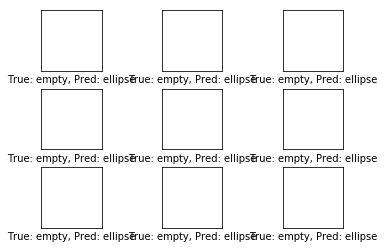

Confusion Matrix:
[[5043    0]
 [4957    0]]


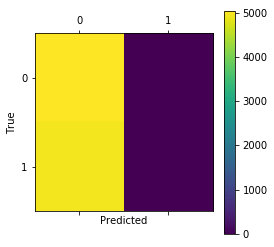

In [58]:
optimize(num_iterations=9)  # We already performed 1 iteration above.
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 1.445, Type Loss: 0.697, Shape Loss: 0.749
Total Loss: 1.410, Type Loss: 0.687, Shape Loss: 0.724
Total Loss: 1.419, Type Loss: 0.704, Shape Loss: 0.715
Total Loss: 1.329, Type Loss: 0.691, Shape Loss: 0.638
Total Loss: 1.231, Type Loss: 0.668, Shape Loss: 0.563
Total Loss: 1.288, Type Loss: 0.678, Shape Loss: 0.610
Total Loss: 1.244, Type Loss: 0.669, Shape Loss: 0.574
Total Loss: 1.214, Type Loss: 0.660, Shape Loss: 0.554
Total Loss: 1.214, Type Loss: 0.655, Shape Loss: 0.559
Total Loss: 1.201, Type Loss: 0.660, Shape Loss: 0.541
Time elapsed: 0:00:05
Accuracy on Test-Set: 50.4% (5043 / 10000)
Error of shape detection on Test-Set: 1.7
Example errors:


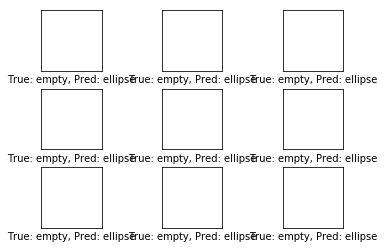

Confusion Matrix:
[[5043    0]
 [4957    0]]


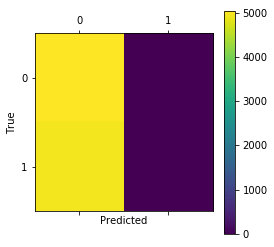

In [59]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 1.253, Type Loss: 0.663, Shape Loss: 0.589
Total Loss: 1.228, Type Loss: 0.683, Shape Loss: 0.545
Total Loss: 1.262, Type Loss: 0.659, Shape Loss: 0.603
Total Loss: 1.218, Type Loss: 0.675, Shape Loss: 0.544
Total Loss: 1.242, Type Loss: 0.632, Shape Loss: 0.609
Total Loss: 1.137, Type Loss: 0.625, Shape Loss: 0.513
Total Loss: 1.175, Type Loss: 0.647, Shape Loss: 0.528
Total Loss: 1.138, Type Loss: 0.655, Shape Loss: 0.482
Total Loss: 1.160, Type Loss: 0.654, Shape Loss: 0.506
Total Loss: 1.140, Type Loss: 0.634, Shape Loss: 0.506
Time elapsed: 0:00:05
Accuracy on Test-Set: 95.3% (9528 / 10000)
Error of shape detection on Test-Set: 1.6
Example errors:


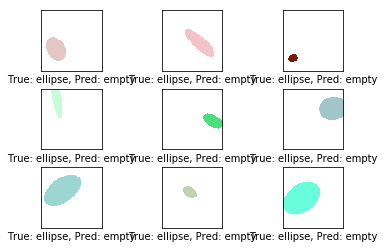

Confusion Matrix:
[[4580  463]
 [   9 4948]]


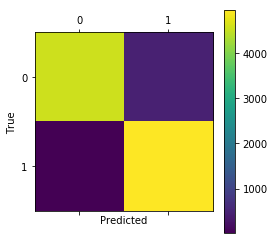

In [60]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 1.184, Type Loss: 0.627, Shape Loss: 0.557
Total Loss: 1.121, Type Loss: 0.640, Shape Loss: 0.481
Total Loss: 1.137, Type Loss: 0.637, Shape Loss: 0.501
Total Loss: 1.058, Type Loss: 0.615, Shape Loss: 0.442
Total Loss: 1.158, Type Loss: 0.630, Shape Loss: 0.528
Total Loss: 1.144, Type Loss: 0.610, Shape Loss: 0.534
Total Loss: 1.116, Type Loss: 0.603, Shape Loss: 0.513
Total Loss: 1.160, Type Loss: 0.593, Shape Loss: 0.567
Total Loss: 1.103, Type Loss: 0.610, Shape Loss: 0.493
Total Loss: 1.069, Type Loss: 0.594, Shape Loss: 0.475
Time elapsed: 0:00:05
Accuracy on Test-Set: 50.4% (5043 / 10000)
Error of shape detection on Test-Set: 1.5
Example errors:


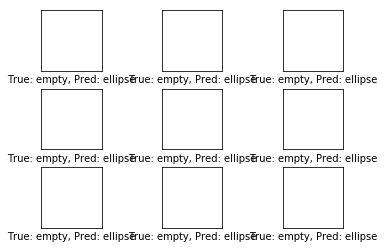

Confusion Matrix:
[[5043    0]
 [4957    0]]


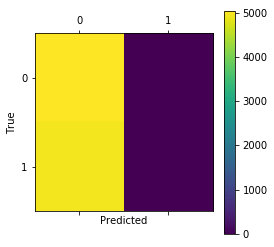

In [61]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 1.074, Type Loss: 0.637, Shape Loss: 0.437
Total Loss: 1.085, Type Loss: 0.600, Shape Loss: 0.485
Total Loss: 1.031, Type Loss: 0.561, Shape Loss: 0.470
Total Loss: 0.970, Type Loss: 0.558, Shape Loss: 0.411
Total Loss: 1.017, Type Loss: 0.584, Shape Loss: 0.432
Total Loss: 1.051, Type Loss: 0.582, Shape Loss: 0.469
Total Loss: 1.033, Type Loss: 0.527, Shape Loss: 0.506
Total Loss: 0.960, Type Loss: 0.577, Shape Loss: 0.383
Total Loss: 0.911, Type Loss: 0.537, Shape Loss: 0.374
Total Loss: 0.935, Type Loss: 0.532, Shape Loss: 0.404
Time elapsed: 0:00:05
Accuracy on Test-Set: 91.2% (9116 / 10000)
Error of shape detection on Test-Set: 1.4
Example errors:


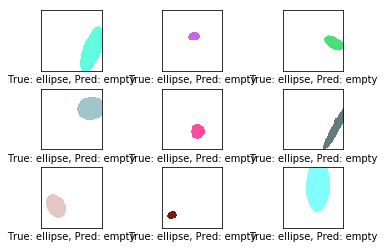

Confusion Matrix:
[[4168  875]
 [   9 4948]]


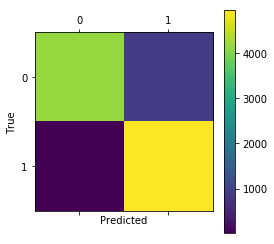

In [62]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.945, Type Loss: 0.519, Shape Loss: 0.426
Total Loss: 0.934, Type Loss: 0.527, Shape Loss: 0.408
Total Loss: 0.991, Type Loss: 0.540, Shape Loss: 0.451
Total Loss: 0.868, Type Loss: 0.526, Shape Loss: 0.342
Total Loss: 0.849, Type Loss: 0.500, Shape Loss: 0.349
Total Loss: 0.878, Type Loss: 0.479, Shape Loss: 0.399
Total Loss: 0.884, Type Loss: 0.487, Shape Loss: 0.397
Total Loss: 0.797, Type Loss: 0.466, Shape Loss: 0.331
Total Loss: 0.677, Type Loss: 0.437, Shape Loss: 0.240
Total Loss: 0.849, Type Loss: 0.490, Shape Loss: 0.358
Time elapsed: 0:00:05
Accuracy on Test-Set: 89.5% (8950 / 10000)
Error of shape detection on Test-Set: 1.3
Example errors:


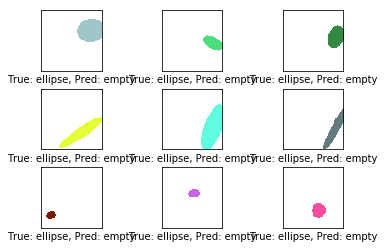

Confusion Matrix:
[[4002 1041]
 [   9 4948]]


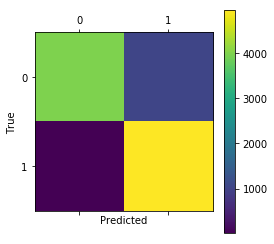

In [63]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.637, Type Loss: 0.384, Shape Loss: 0.253
Total Loss: 0.862, Type Loss: 0.496, Shape Loss: 0.367
Total Loss: 0.711, Type Loss: 0.409, Shape Loss: 0.303
Total Loss: 0.690, Type Loss: 0.355, Shape Loss: 0.334
Total Loss: 0.642, Type Loss: 0.392, Shape Loss: 0.250
Total Loss: 0.688, Type Loss: 0.408, Shape Loss: 0.280
Total Loss: 0.819, Type Loss: 0.445, Shape Loss: 0.375
Total Loss: 0.577, Type Loss: 0.372, Shape Loss: 0.205
Total Loss: 0.547, Type Loss: 0.329, Shape Loss: 0.218
Total Loss: 0.646, Type Loss: 0.382, Shape Loss: 0.264
Time elapsed: 0:00:05
Accuracy on Test-Set: 91.1% (9106 / 10000)
Error of shape detection on Test-Set: 1.1
Example errors:


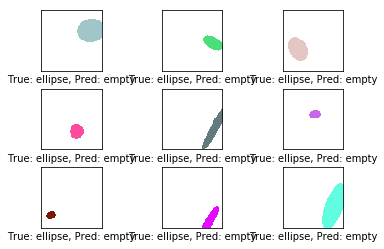

Confusion Matrix:
[[4158  885]
 [   9 4948]]


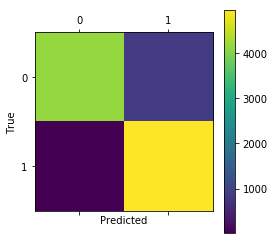

In [64]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.604, Type Loss: 0.359, Shape Loss: 0.245
Total Loss: 0.623, Type Loss: 0.312, Shape Loss: 0.311
Total Loss: 0.593, Type Loss: 0.335, Shape Loss: 0.258
Total Loss: 0.617, Type Loss: 0.346, Shape Loss: 0.270
Total Loss: 0.613, Type Loss: 0.364, Shape Loss: 0.249
Total Loss: 0.643, Type Loss: 0.338, Shape Loss: 0.306
Total Loss: 0.524, Type Loss: 0.286, Shape Loss: 0.238
Total Loss: 0.555, Type Loss: 0.332, Shape Loss: 0.223
Total Loss: 0.443, Type Loss: 0.246, Shape Loss: 0.196
Total Loss: 0.488, Type Loss: 0.260, Shape Loss: 0.228
Time elapsed: 0:00:05
Accuracy on Test-Set: 92.5% (9248 / 10000)
Error of shape detection on Test-Set: 1.0
Example errors:


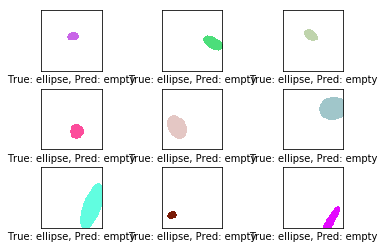

Confusion Matrix:
[[4300  743]
 [   9 4948]]


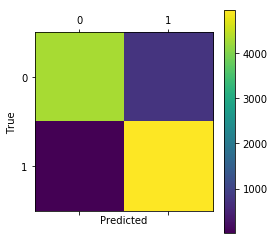

In [65]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.485, Type Loss: 0.256, Shape Loss: 0.229
Total Loss: 0.517, Type Loss: 0.258, Shape Loss: 0.259
Total Loss: 0.534, Type Loss: 0.285, Shape Loss: 0.248
Total Loss: 0.573, Type Loss: 0.263, Shape Loss: 0.309
Total Loss: 0.509, Type Loss: 0.270, Shape Loss: 0.240
Total Loss: 0.495, Type Loss: 0.295, Shape Loss: 0.200
Total Loss: 0.498, Type Loss: 0.239, Shape Loss: 0.259
Total Loss: 0.372, Type Loss: 0.230, Shape Loss: 0.143
Total Loss: 0.403, Type Loss: 0.225, Shape Loss: 0.179
Total Loss: 0.336, Type Loss: 0.207, Shape Loss: 0.128
Time elapsed: 0:00:06
Accuracy on Test-Set: 92.7% (9267 / 10000)
Error of shape detection on Test-Set: 1.0
Example errors:


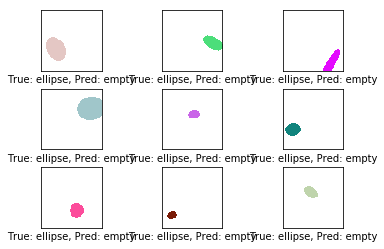

Confusion Matrix:
[[4319  724]
 [   9 4948]]


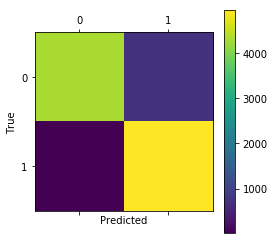

In [66]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.332, Type Loss: 0.210, Shape Loss: 0.122
Total Loss: 0.397, Type Loss: 0.247, Shape Loss: 0.150
Total Loss: 0.438, Type Loss: 0.219, Shape Loss: 0.219
Total Loss: 0.395, Type Loss: 0.232, Shape Loss: 0.163
Total Loss: 0.510, Type Loss: 0.291, Shape Loss: 0.219
Total Loss: 0.394, Type Loss: 0.214, Shape Loss: 0.180
Total Loss: 0.500, Type Loss: 0.293, Shape Loss: 0.207
Total Loss: 0.351, Type Loss: 0.204, Shape Loss: 0.147
Total Loss: 0.578, Type Loss: 0.277, Shape Loss: 0.302
Total Loss: 0.419, Type Loss: 0.226, Shape Loss: 0.193
Time elapsed: 0:00:06
Accuracy on Test-Set: 98.1% (9807 / 10000)
Error of shape detection on Test-Set: 0.96
Example errors:


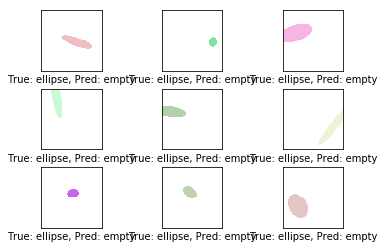

Confusion Matrix:
[[4859  184]
 [   9 4948]]


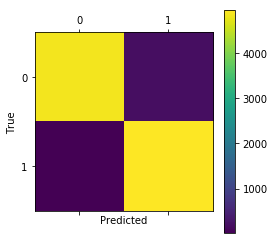

In [67]:
optimize(num_iterations=10)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.372, Type Loss: 0.205, Shape Loss: 0.168
Total Loss: 0.381, Type Loss: 0.194, Shape Loss: 0.187
Total Loss: 0.318, Type Loss: 0.206, Shape Loss: 0.113
Total Loss: 0.313, Type Loss: 0.187, Shape Loss: 0.126
Total Loss: 0.403, Type Loss: 0.203, Shape Loss: 0.201
Total Loss: 0.495, Type Loss: 0.238, Shape Loss: 0.257
Total Loss: 0.311, Type Loss: 0.130, Shape Loss: 0.180
Total Loss: 0.365, Type Loss: 0.171, Shape Loss: 0.194
Total Loss: 0.338, Type Loss: 0.192, Shape Loss: 0.146
Total Loss: 0.305, Type Loss: 0.160, Shape Loss: 0.144
Total Loss: 0.308, Type Loss: 0.165, Shape Loss: 0.143
Total Loss: 0.404, Type Loss: 0.178, Shape Loss: 0.226
Total Loss: 0.268, Type Loss: 0.124, Shape Loss: 0.144
Total Loss: 0.370, Type Loss: 0.174, Shape Loss: 0.196
Total Loss: 0.275, Type Loss: 0.159, Shape Loss: 0.116
Total Loss: 0.300, Type Loss: 0.130, Shape Loss: 0.170
Total Loss: 0.260, Type Loss: 0.117, Shape Loss: 0.142
Total Loss: 0.262, Type Loss: 0.120, Shape Loss: 0.142
Total Loss

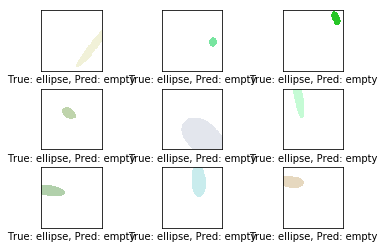

Confusion Matrix:
[[4976   67]
 [   9 4948]]


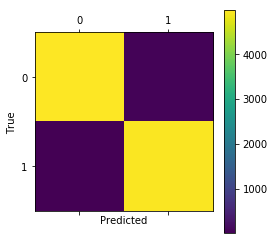

In [68]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.105, Type Loss: 0.037, Shape Loss: 0.068
Total Loss: 0.169, Type Loss: 0.040, Shape Loss: 0.129
Total Loss: 0.086, Type Loss: 0.031, Shape Loss: 0.056
Total Loss: 0.103, Type Loss: 0.024, Shape Loss: 0.079
Total Loss: 0.142, Type Loss: 0.074, Shape Loss: 0.068
Total Loss: 0.135, Type Loss: 0.038, Shape Loss: 0.097
Total Loss: 0.090, Type Loss: 0.019, Shape Loss: 0.071
Total Loss: 0.113, Type Loss: 0.028, Shape Loss: 0.085
Total Loss: 0.087, Type Loss: 0.016, Shape Loss: 0.071
Total Loss: 0.101, Type Loss: 0.042, Shape Loss: 0.059
Total Loss: 0.100, Type Loss: 0.024, Shape Loss: 0.076
Total Loss: 0.158, Type Loss: 0.043, Shape Loss: 0.115
Total Loss: 0.110, Type Loss: 0.021, Shape Loss: 0.089
Total Loss: 0.080, Type Loss: 0.023, Shape Loss: 0.057
Total Loss: 0.151, Type Loss: 0.053, Shape Loss: 0.097
Total Loss: 0.164, Type Loss: 0.026, Shape Loss: 0.138
Total Loss: 0.086, Type Loss: 0.016, Shape Loss: 0.070
Total Loss: 0.063, Type Loss: 0.022, Shape Loss: 0.042
Total Loss

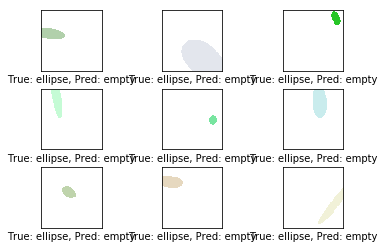

Confusion Matrix:
[[4973   70]
 [   9 4948]]


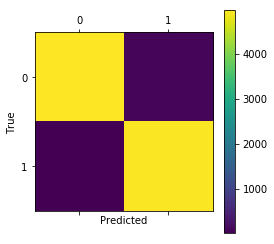

In [69]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.132, Type Loss: 0.033, Shape Loss: 0.099
Total Loss: 0.056, Type Loss: 0.009, Shape Loss: 0.048
Total Loss: 0.060, Type Loss: 0.008, Shape Loss: 0.052
Total Loss: 0.109, Type Loss: 0.014, Shape Loss: 0.095
Total Loss: 0.094, Type Loss: 0.028, Shape Loss: 0.066
Total Loss: 0.084, Type Loss: 0.011, Shape Loss: 0.074
Total Loss: 0.198, Type Loss: 0.102, Shape Loss: 0.096
Total Loss: 0.103, Type Loss: 0.012, Shape Loss: 0.091
Total Loss: 0.067, Type Loss: 0.020, Shape Loss: 0.047
Total Loss: 0.073, Type Loss: 0.010, Shape Loss: 0.063
Total Loss: 0.055, Type Loss: 0.009, Shape Loss: 0.047
Total Loss: 0.099, Type Loss: 0.011, Shape Loss: 0.088
Total Loss: 0.087, Type Loss: 0.013, Shape Loss: 0.074
Total Loss: 0.066, Type Loss: 0.007, Shape Loss: 0.059
Total Loss: 0.130, Type Loss: 0.067, Shape Loss: 0.063
Total Loss: 0.113, Type Loss: 0.048, Shape Loss: 0.065
Total Loss: 0.125, Type Loss: 0.031, Shape Loss: 0.095
Total Loss: 0.079, Type Loss: 0.010, Shape Loss: 0.069
Total Loss

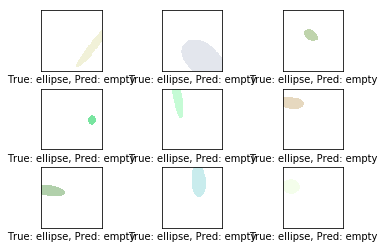

Confusion Matrix:
[[4986   57]
 [   9 4948]]


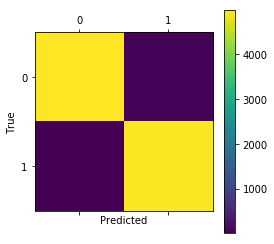

In [70]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.210, Type Loss: 0.087, Shape Loss: 0.123
Total Loss: 0.103, Type Loss: 0.012, Shape Loss: 0.091
Total Loss: 0.116, Type Loss: 0.048, Shape Loss: 0.068
Total Loss: 0.063, Type Loss: 0.011, Shape Loss: 0.052
Total Loss: 0.075, Type Loss: 0.008, Shape Loss: 0.067
Total Loss: 0.062, Type Loss: 0.007, Shape Loss: 0.055
Total Loss: 0.067, Type Loss: 0.008, Shape Loss: 0.058
Total Loss: 0.075, Type Loss: 0.018, Shape Loss: 0.058
Total Loss: 0.125, Type Loss: 0.055, Shape Loss: 0.071
Total Loss: 0.075, Type Loss: 0.010, Shape Loss: 0.065
Total Loss: 0.069, Type Loss: 0.009, Shape Loss: 0.060
Total Loss: 0.069, Type Loss: 0.011, Shape Loss: 0.059
Total Loss: 0.082, Type Loss: 0.007, Shape Loss: 0.075
Total Loss: 0.072, Type Loss: 0.013, Shape Loss: 0.060
Total Loss: 0.079, Type Loss: 0.008, Shape Loss: 0.071
Total Loss: 0.047, Type Loss: 0.009, Shape Loss: 0.038
Total Loss: 0.063, Type Loss: 0.011, Shape Loss: 0.052
Total Loss: 0.075, Type Loss: 0.008, Shape Loss: 0.067
Total Loss

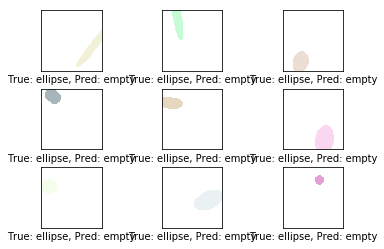

Confusion Matrix:
[[5017   26]
 [   9 4948]]


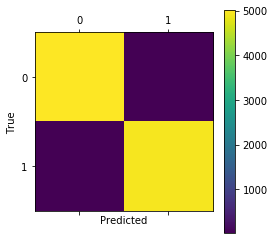

In [71]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.047, Type Loss: 0.008, Shape Loss: 0.039
Total Loss: 0.082, Type Loss: 0.018, Shape Loss: 0.065
Total Loss: 0.101, Type Loss: 0.004, Shape Loss: 0.098
Total Loss: 0.062, Type Loss: 0.004, Shape Loss: 0.058
Total Loss: 0.053, Type Loss: 0.004, Shape Loss: 0.049
Total Loss: 0.107, Type Loss: 0.005, Shape Loss: 0.102
Total Loss: 0.073, Type Loss: 0.003, Shape Loss: 0.070
Total Loss: 0.044, Type Loss: 0.004, Shape Loss: 0.040
Total Loss: 0.072, Type Loss: 0.011, Shape Loss: 0.061
Total Loss: 0.069, Type Loss: 0.006, Shape Loss: 0.063
Total Loss: 0.078, Type Loss: 0.004, Shape Loss: 0.073
Total Loss: 0.061, Type Loss: 0.005, Shape Loss: 0.056
Total Loss: 0.060, Type Loss: 0.005, Shape Loss: 0.055
Total Loss: 0.051, Type Loss: 0.005, Shape Loss: 0.046
Total Loss: 0.061, Type Loss: 0.005, Shape Loss: 0.056
Total Loss: 0.044, Type Loss: 0.003, Shape Loss: 0.041
Total Loss: 0.078, Type Loss: 0.005, Shape Loss: 0.073
Total Loss: 0.074, Type Loss: 0.003, Shape Loss: 0.070
Total Loss

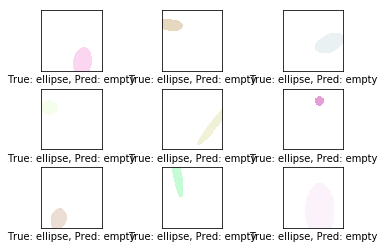

Confusion Matrix:
[[5019   24]
 [   9 4948]]


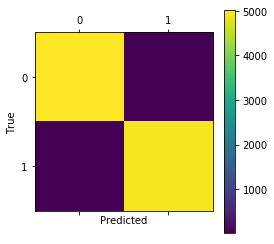

In [72]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.094, Type Loss: 0.008, Shape Loss: 0.086
Total Loss: 0.070, Type Loss: 0.004, Shape Loss: 0.066
Total Loss: 0.061, Type Loss: 0.004, Shape Loss: 0.057
Total Loss: 0.059, Type Loss: 0.004, Shape Loss: 0.054
Total Loss: 0.097, Type Loss: 0.003, Shape Loss: 0.094
Total Loss: 0.064, Type Loss: 0.005, Shape Loss: 0.059
Total Loss: 0.067, Type Loss: 0.013, Shape Loss: 0.054
Total Loss: 0.081, Type Loss: 0.004, Shape Loss: 0.076
Total Loss: 0.041, Type Loss: 0.004, Shape Loss: 0.037
Total Loss: 0.068, Type Loss: 0.003, Shape Loss: 0.065
Total Loss: 0.122, Type Loss: 0.045, Shape Loss: 0.077
Total Loss: 0.066, Type Loss: 0.003, Shape Loss: 0.063
Total Loss: 0.066, Type Loss: 0.005, Shape Loss: 0.061
Total Loss: 0.058, Type Loss: 0.004, Shape Loss: 0.054
Total Loss: 0.070, Type Loss: 0.004, Shape Loss: 0.066
Total Loss: 0.066, Type Loss: 0.005, Shape Loss: 0.062
Total Loss: 0.055, Type Loss: 0.004, Shape Loss: 0.051
Total Loss: 0.052, Type Loss: 0.003, Shape Loss: 0.048
Total Loss

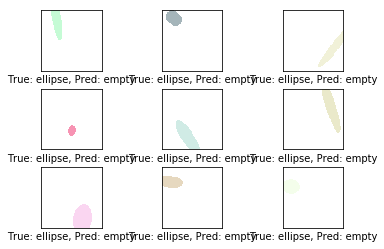

Confusion Matrix:
[[5005   38]
 [   9 4948]]


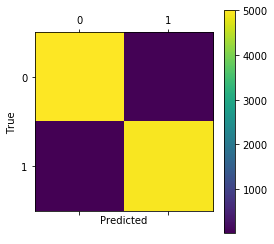

In [73]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.044, Type Loss: 0.002, Shape Loss: 0.042
Total Loss: 0.057, Type Loss: 0.002, Shape Loss: 0.056
Total Loss: 0.064, Type Loss: 0.002, Shape Loss: 0.061
Total Loss: 0.178, Type Loss: 0.073, Shape Loss: 0.105
Total Loss: 0.074, Type Loss: 0.001, Shape Loss: 0.072
Total Loss: 0.054, Type Loss: 0.003, Shape Loss: 0.050
Total Loss: 0.057, Type Loss: 0.003, Shape Loss: 0.053
Total Loss: 0.071, Type Loss: 0.031, Shape Loss: 0.039
Total Loss: 0.073, Type Loss: 0.003, Shape Loss: 0.071
Total Loss: 0.051, Type Loss: 0.006, Shape Loss: 0.045
Total Loss: 0.247, Type Loss: 0.117, Shape Loss: 0.129
Total Loss: 0.161, Type Loss: 0.088, Shape Loss: 0.073
Total Loss: 0.321, Type Loss: 0.158, Shape Loss: 0.163
Total Loss: 0.066, Type Loss: 0.002, Shape Loss: 0.064
Total Loss: 0.087, Type Loss: 0.002, Shape Loss: 0.085
Total Loss: 0.092, Type Loss: 0.002, Shape Loss: 0.090
Total Loss: 0.225, Type Loss: 0.087, Shape Loss: 0.138
Total Loss: 0.348, Type Loss: 0.166, Shape Loss: 0.182
Total Loss

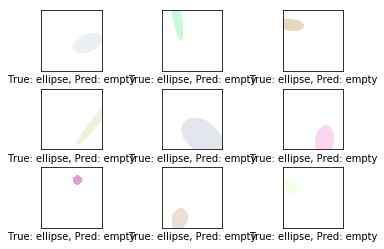

Confusion Matrix:
[[5016   27]
 [   9 4948]]


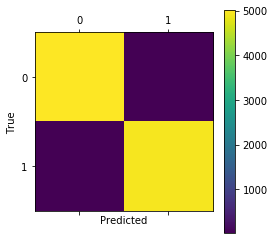

In [74]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.072, Type Loss: 0.033, Shape Loss: 0.039
Total Loss: 0.069, Type Loss: 0.004, Shape Loss: 0.065
Total Loss: 0.092, Type Loss: 0.004, Shape Loss: 0.088
Total Loss: 0.086, Type Loss: 0.004, Shape Loss: 0.081
Total Loss: 0.115, Type Loss: 0.016, Shape Loss: 0.099
Total Loss: 0.059, Type Loss: 0.004, Shape Loss: 0.055
Total Loss: 0.106, Type Loss: 0.053, Shape Loss: 0.054
Total Loss: 0.072, Type Loss: 0.006, Shape Loss: 0.066
Total Loss: 0.088, Type Loss: 0.008, Shape Loss: 0.081
Total Loss: 0.083, Type Loss: 0.008, Shape Loss: 0.075
Total Loss: 0.049, Type Loss: 0.007, Shape Loss: 0.042
Total Loss: 0.060, Type Loss: 0.005, Shape Loss: 0.056
Total Loss: 0.214, Type Loss: 0.108, Shape Loss: 0.106
Total Loss: 0.050, Type Loss: 0.004, Shape Loss: 0.046
Total Loss: 0.042, Type Loss: 0.005, Shape Loss: 0.037
Total Loss: 0.093, Type Loss: 0.025, Shape Loss: 0.068
Total Loss: 0.067, Type Loss: 0.005, Shape Loss: 0.062
Total Loss: 0.062, Type Loss: 0.007, Shape Loss: 0.055
Total Loss

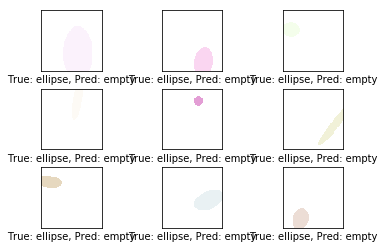

Confusion Matrix:
[[5019   24]
 [   9 4948]]


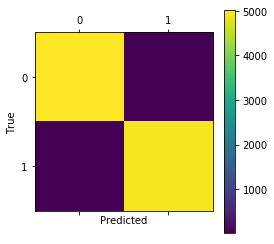

In [75]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Total Loss: 0.055, Type Loss: 0.002, Shape Loss: 0.053
Total Loss: 0.094, Type Loss: 0.011, Shape Loss: 0.083
Total Loss: 0.041, Type Loss: 0.003, Shape Loss: 0.039
Total Loss: 0.054, Type Loss: 0.002, Shape Loss: 0.052
Total Loss: 0.073, Type Loss: 0.002, Shape Loss: 0.071
Total Loss: 0.046, Type Loss: 0.003, Shape Loss: 0.043
Total Loss: 0.063, Type Loss: 0.001, Shape Loss: 0.061
Total Loss: 0.065, Type Loss: 0.002, Shape Loss: 0.063
Total Loss: 0.081, Type Loss: 0.019, Shape Loss: 0.062
Total Loss: 0.052, Type Loss: 0.013, Shape Loss: 0.039
Total Loss: 0.055, Type Loss: 0.002, Shape Loss: 0.053
Total Loss: 0.049, Type Loss: 0.003, Shape Loss: 0.046
Total Loss: 0.115, Type Loss: 0.001, Shape Loss: 0.114
Total Loss: 0.066, Type Loss: 0.007, Shape Loss: 0.059
Total Loss: 0.055, Type Loss: 0.003, Shape Loss: 0.052
Total Loss: 0.070, Type Loss: 0.002, Shape Loss: 0.068
Total Loss: 0.056, Type Loss: 0.003, Shape Loss: 0.053
Total Loss: 0.050, Type Loss: 0.003, Shape Loss: 0.047
Total Loss

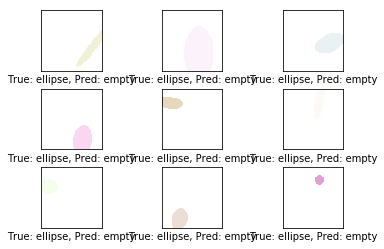

Confusion Matrix:
[[5023   20]
 [   9 4948]]


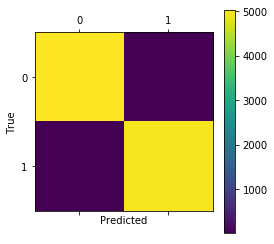

In [76]:
optimize(num_iterations=100)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [77]:
for i in range(test_images.shape[0]):
    print_test_accuracy(i)

(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 22.  35.  30.  27. 171.]]
[[ 25.  38.  31.  28. 219.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  38.  25.  19. 199.]]
[[ 41.  43.  28.  26. 320.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -1.  42.  23.  13. 186.]]
[[  3.  44.  18.  16. 274.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(1


[[ 23.  41.  21.   9. 187.]]
[[ 23.  41.  18.  13. 110.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  41.  22.  12. 200.]]
[[ 5. 36. 14. 12. 96.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 17.  32.  21.  11. 214.]]
[[ 18.  30.  23.   9. 307.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.  36.  17.   7. 161.]]
[[ 0. 33. 29.  4.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 20.  24.  22.   7. 202.]]
[[ 21.  21.  21.   4. 288.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 23.  44.  17.   3. 192.]]
[[ 22.  41.  15.   5. 166.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000,

[[  3.   9.  31.   7. 226.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  43.  21.  12. 174.]]
[[  8.  44.  17.  15. 269.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  18.  29.  24. 171.]]
[[ 19.  18.  26.  25. 196.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  28.  22.  13. 199.]]
[[ 37.  28.  17.  15. 245.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  39.  23.  13. 196.]]
[[ 40.  33.  21.  13. 312.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -7.  19.  27.  12. 162.]]
[[ 1. 16. 29.  9. 89.]]
(10000

(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 33.  43.  22.   9. 229.]]
[[ 31.  43.  27.   7. 319.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  26.  20.   9. 188.]]
[[ 21.  25.  14.  13. 305.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 33.  28.  24.  18. 169.]]
[[ 37.  29.  28.  16. 204.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  38.  21.   8. 246.]]
[[ 31.  34.  28.   4. 146.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  31.  15.   7. 167.]]
[[ 43.  32.  17.   9. 107.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  29.  22.  10. 202.]]
[[  2.  31.  29.  10. 295.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  35.  13.   7. 174.]]
[[ 1. 33. 15.  5.  9.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 

(10000, 5)
(1, 5)

[[  5.  43.  18.   8. 184.]]
[[  3.  46.  24.   8. 322.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  7.  45.  21.  13. 157.]]
[[ 16.  46.  31.   9. 216.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 20.  -4.  20.   9. 192.]]
[[ 22.   0.  14.   8. 177.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 27.   0.  25.  15. 159.]]
[[ 26.   3.  23.  11. 198.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.  10.  16.   7. 203.]]
[[ 6. 10. 10.  9. 71.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 15.   6.  19.   9. 224.]]
[[ 17.   4.  17.  13. 148.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.  40.  24.  15. 192.]]
[[  1.  35.  26.  17. 199.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 32.  12.  25.  15. 200.]]
[[ 32.  10.  27.  13. 107.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 14.  15.  23.  16. 170.]]
[[ 18.  14.  28.  14.

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  12.  27.  23. 151.]]
[[40. 14. 30. 29. 32.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.   8.  24.  13. 198.]]
[[ 33.   4.  25.  15. 150.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 21.  44.  24.   9. 179.]]
[[ 15.  41.  31.   9. 179.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 17.  19.  25.  19. 161.]]
[[22. 17. 25. 19. 26.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.  16.  18.  10. 222.]]
[[  9.  15.  16.  13.

[[ 43.   4.  33.  22. 171.]]
[[ 38.   4.  26.  21. 251.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  36.  17.   7. 176.]]
[[ 46.  38.  24.   4. 207.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  36.  21.  12. 182.]]
[[ 11.  35.  16.  15. 288.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  35.  18.   7. 204.]]
[[ 34.  35.  13.  10. 311.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 32.  23.  22.   9. 182.]]
[[ 30.  24.  30.   5. 274.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 23.  14.  26.  13. 161.]]
[[ 23.   9.  26.   9. 199.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 45.  37.  16.   5. 164.]]
[[47. 40.  9.  4. 29.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 17.   6.  20

(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 22.  23.  22.  10. 189.]]
[[ 24.  23.  23.  22. 347.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  33.  17.   7. 176.]]
[[  7.  33.  23.   4. 164.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.  18.  18.  10. 248.]]
[[  2.  20.  29.   6. 339.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  0.   5.  

[[ 28.  43.  20.   7. 211.]]
[[ 32.  40.  30.   4. 158.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 22.  47.  17.   9. 133.]]
[[28. 46. 24.  5. 44.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.   8.  25.  15. 197.]]
[[ 34.   5.  29.  13. 318.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  7.  16.  29.  23. 184.]]
[[ 12.  16.  31.  22. 298.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.

(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  25.  24.  18. 149.]]
[[22. 23. 28. 17. 15.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 44.  10.  27.  16. 184.]]
[[40. 11. 21. 16. 89.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 25.  24.  20.  11. 216.]]
[[ 26.  24.  17.  14. 331.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.   7.  22.  16. 220.]]
[[  8.   5.  20.  19. 256.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(1

(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 28.   9.  18.   7. 176.]]
[[ 37.   9.  30.   5. 186.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.  17.  21.   9. 210.]]
[[ 29.  19.  22.   6. 336.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 33.  18.  27.  17. 249.]]
[[ 34.  18.  31.  11. 315.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  10.  18.  11. 214.]]
[[11. 11. 15. 10. 45.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 21.  17.  17.   7. 211.]]
[[ 21.  16.  16.   8. 130.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  35.  23.  17. 146.]]
[[ 28.  35.  24.  16. 202.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1,

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.   9.  24.  14. 199.]]
[[28. 10. 23. 11. 98.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.  29.  29.  23. 176.]]
[[  2.  28.  28.  26. 344.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.   6.  27.  22. 197.]]
[[  6.   9.  29.  22. 324.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  17.  17.   7. 197.]]
[[17. 17. 18.  7. 74.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  41.  24.  17. 174.]]
[[ 39.  37.  19.  17. 348.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.   5.  29.  18. 187.]]
[[ 42.   5.  22.  21. 187.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  43.  20.   8. 133.]]
[

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(1

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  1.  43.  23.  12. 192.]]
[[ 6. 38. 17. 10. 57.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 25.   1.  21.   9. 196.]]
[[ 24.   1.  18.  10. 246.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.   5.  19.   9. 176.]]
[[42.  3. 14. 13. 34.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 

(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 14.  37.  12.   6. 165.]]
[[15. 47.  4.  4. 62.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  24.  20.   7. 214.]]
[[ 35.  22.  31.   4. 106.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  38.  22.  10. 151.]]
[[ 19.  36.  27.  10. 201.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  22.  22.  

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  36.  11.   7. 156.]]
[[29. 38.  9.  8. 85.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 28.  24.  14.   7. 183.]]
[[ 26.  22.   7.   4. 128.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.   7.  30.  28. 189.]]
[[ 16.   6.  30.  25. 310.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.  11.  25.  20. 191.]]
[[  8.  10.  26.  22. 199.

(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 46.  -1.  24.   9. 179.]]
[[40.  0. 17.  7. 48.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  1.  -1.  21.  11. 202.]]
[[  2.   0.  21.  12. 336.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.   4.  27.  13. 229.]]
[[ 37.   4.  23.   9. 140.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5. 

(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  20.  18.  11. 206.]]
[[ 14.  19.  14.  13. 171.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.   8.  31.  21. 143.]]
[[ 44.   5.  31.  25. 232.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  15.  25.  17. 164.]]
[[ 14.  12.  31.  16. 235.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(1

[[  8.   6.  26.  23. 194.]]
[[  5.   1.  31.  31. 181.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.   0.  19.   7. 192.]]
[[24.  2. 13.  6. 21.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 46.   8.  22.   7. 211.]]
[[ 42.  10.  13.   9. 112.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  13.  16.   5. 220.]]
[[ 18.  11.  16.   7. 355.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 24.  12.  30.  24. 173.]]
[[ 26.  13.  28.  24. 273.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  

[[  8.  22.  25.  18. 177.]]
[[  9.  23.  28.  19. 356.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 45.  23.  19.   6. 193.]]
[[ 46.  20.  15.   4. 357.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.  46.  23.  14. 192.]]
[[ 10.  41.  19.  12. 331.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.  26.  22.   6. 193.]]
[[40. 25. 21.  7. 66.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.

[[  7.  26.   8.   3. 127.]]
[[ 10.  37.   6.   4. 113.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.  32.  20.  11. 137.]]
[[ 30.  29.  27.   9. 238.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  38.  21.  12. 185.]]
[[  1.  46.  31.  18. 273.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  31.  30.  27. 162.]]
[[ 34.  28.  29.  27. 193.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  10.  15.   7. 209.]]
[[ 5.  7. 13.  7. 77.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  

(1, 2)
(10000, 5)
(1, 5)

[[ 10.  13.  22.  13. 207.]]
[[  8.  10.  22.  22. 343.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.   8.  17.   6. 233.]]
[[ 12.   6.  14.   5. 336.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  45.  21.   8. 190.]]
[[ 47.  44.  23.  15. 334.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.   8.  32.  24. 146.]]
[[ 43.   6.  29.  29. 311.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.   8.  15.   6. 177.]]
[[ 34.   6.  10.   7. 340.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  

[[ 17.   4.  25.  19. 199.]]
[[19.  3. 25. 20. 11.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.  29.  22.  12. 181.]]
[[ 1. 24. 25. 14. 41.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.   3.  30.  19. 188.]]
[[ 38.   5.  21.  18. 226.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 16.  30.  27.  17. 194.]]
[[ 16.  31.  31.  14. 103.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(1


[[ 26.  47.  29.  25. 167.]]
[[ 28.  46.  29.  28. 201.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 49.  23.  25.  11. 152.]]
[[ 46.  25.  26.  12. 241.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  17.  13.   7. 168.]]
[[ 42.  17.  13.  12. 354.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 27.  39.  12.   5. 170.]]
[[ 29.  40.   7.   4. 339.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.   3.  27.  15. 193.]]
[[ 33.   2.  28.  13. 166.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  12.  23.  17. 223.]]
[[  8.  14.  20.  14. 130.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.   6.  21.  14. 215.]]
[[10.  0. 27. 12. 73.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  12.  25.  17. 174.]]
[[ 33.  13.  17.  17. 300.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  45.  25.  16. 172.]]
[[ 20.  44.  25.  19. 270.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.   5.  28.  19. 167.]]
[[ 36.  10.  22.  15. 218.]]
(

(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 15.  45.  21.  10. 208.]]
[[ 16.  41.  21.   7. 312.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.  12.  16.   4. 189.]]
[[43. 11.  8.  6.  1.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 20.   7.  18.   9. 206.]]
[[ 15.   5.  23.  10. 352.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  14.  21.  10. 209.]]
[[  1.  16.  19.  12. 315.]]
(10000, 64,

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  42.  28.  20. 182.]]
[[ 18.  40.  29.  20. 147.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.  56.  28.  18. 184.]]
[[ 30.  46.  30.  12. 339.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 16.  24.  10.   5. 176.]]
[[ 18.  26.   5.   4. 227.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  0.   7.  21.  13. 205.]]
[[  4.   9.  16.  14.

[[  6.  27.  20.  10. 205.]]
[[ 5. 25. 17. 10. 15.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  33.  21.  10. 164.]]
[[ 11.  31.  20.   8. 354.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  16.  26.  17. 196.]]
[[  3.  16.  28.  22. 243.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.   8.  17.   7. 250.]]
[[ 10.   9.  17.   6. 127.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.

(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  0.  36.  27.  19. 211.]]
[[  2.  35.  26.  20. 326.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  40.  21.  13. 122.]]
[[ 38.  39.  30.   8. 204.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 32.  35.  15.   5. 191.]]
[[31. 34.  9.  5. 58.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.  42.  19.   6. 188.]]
[[ 44.  39.  20.   5. 171.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 24.  

[[ 13.   8.  18.   9. 210.]]
[[ 12.   4.  24.   8. 255.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 14.  10.  18.   6. 215.]]
[[16.  9. 18.  5. 14.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 51.   8.  26.   9. 220.]]
[[ 46.  10.  20.   9. 253.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  33.  17.   6. 198.]]
[[ 41.  29.  11.   7. 320.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  7.  15.  18.   7. 241.]]
[[  1.  20.  30.   4. 308.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  18.  29.  22. 199.]]
[[  2.  20.  29.  22. 312.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  11.  31.  23. 154

(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.   7.  25.  21. 195.]]
[[  6.   2.  29.  28. 257.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 34.  46.  16.   5. 156.]]
[[ 36.  47.  14.   6. 265.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  32.  22.  11. 173.]]
[[11. 30. 22. 12. 34.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.   6.  29.  18. 177.]]
[[ 45.   2.  30.  26. 214.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  1.  47.  22.   9. 174.]]
[[ 6. 40. 22.  6. 51.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  7.  26.  29.  24. 163.]]
[[10. 26. 28. 26. 66.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  26.  29.


[[ 29.   9.  13.   6. 148.]]
[[ 31.   8.  10.   8. 307.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.  31.  23.  16. 133.]]
[[34. 34. 30. 12. 48.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 20.  31.  29.  24. 162.]]
[[22. 33. 27. 27. 33.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  35.  28.  20. 177.]]
[[  5.  34.  24.  24. 282.]]
(

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 22.  28.  19.   8. 200.]]
[[ 22.  26.  14.  11. 348.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.  15.  15.   6. 218.]]
[[ 3. 14. 11.  6. 50.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 27.  41.  14.   7. 159.]]
[[ 28.  43.  13.   7. 126.]]
(10000,

[[  5.  44.  19.   6. 152.]]
[[ 9. 40. 20.  5. 34.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.  41.  27.  19. 182.]]
[[ 12.  38.  19.  18. 308.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  29.  21.  10. 208.]]
[[ 44.  27.  24.  11. 185.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  27.  19.   9. 220.]]
[[ 36.  26.  22.  10. 323.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  15.  21.  14. 174.]]
[[ 18.  14.  22.  11. 208.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  19.  23.  12. 205.]]
[[ 35.  20.  21.  14. 142.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.   9.  24.  12. 186.]]
[[ 25.   8.  20.   8. 269.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.  14.  23.  12. 177.]]
[[ 40.  16.  16.  15. 258.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  19.  22.   6. 179.]]
[[40. 18. 18.  8. 68.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 43.  -6.  28.  11. 169.]]
[[37.  0. 27.  


[[ 36.  17.  16.   6. 186.]]
[[33. 16. 15.  6. 84.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.  40.  17.   5. 202.]]
[[ 37.  38.  10.   8. 144.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 33.  33.  26.  21. 188.]]
[[37. 43. 31. 27. 61.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 27.  30.  24.  12. 195.]]
[[ 27.  35.  31.  12. 102.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  44.  25.  19. 174.]]
[[ 42.  39.  21.  19. 191.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  

(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.  39.  27.  18. 195.]]
[[  3.  43.  29.  21. 107.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  28.  26.  23. 149.]]
[[37. 26. 28. 20. 53.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 25.  47.  21. 

(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.  26.  23.  15. 135.]]
[[ 35.  26.  31.  12. 217.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 49.   3.  23.   8. 208.]]
[[46.  5. 15. 10. 60.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 51.  38.  23.   9. 199.]]
[[ 46.  34.  30.   4. 106.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.   7.  19.  10. 234.]]
[[  2.   6.  20.  12. 138.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.  18.  19.   7. 203.]]
[[  3.  19.  17.   8. 115.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000

[[ 12.  26.  14.   6. 200.]]
[[ 13.  24.  11.   5. 312.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  40.  21.  10. 183.]]
[[35. 42. 18. 18. 43.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 4.  8.  4.  2. 58.]]
[[31. 45. 16.  4. 69.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  29.  26.  20. 162.]]
[[ 43.  28.  29.  21. 184.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 28.  37.  26.  21. 175.]]
[[31. 41. 30. 23. 40.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(1

[[ 20.   6.  18.   5. 223.]]
[[ 24.   5.  15.   4. 342.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -2.  39.  21.  10. 199.]]
[[  1.  36.  16.   8. 120.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  27.  20.  12. 209.]]
[[ 46.  25.  31.   8. 166.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.  46.  21.  12. 171.]]
[[27. 45. 20. 15. 72.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  30.  20.   8. 198.]]
[[ 39.  26.  12.

[[ 15.   6.  26.  21. 196.]]
[[ 17.   1.  28.  25. 328.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  34.  34.  26. 144.]]
[[14. 29. 29. 27. 95.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 23.  44.  15.   7. 169.]]
[[26. 43.  9.  8.  9.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  31.  26.  20. 171.]]
[[ 44.  31.  27.  21. 331.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  39.  23.  14. 188.]]
[[ 40.  39.  22.  20. 160.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.   9.  17.   7. 223.]]
[[  3.   9.

[[ 26.  31.  12.   9. 105.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  36.  28.  23. 193.]]
[[ 36.  35.  31.  16. 309.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 11.   3.  20.   9. 207.]]
[[ 12.   1.  14.   7. 223.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  11.  26.  22. 187.]]
[[ 7.  7. 29. 28. 58.]]
(10000, 64, 64, 3)
(1, 122

[[42. 27. 13.  4. 32.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.   1.  24.  18. 201.]]
[[  9.   0.  24.  20. 112.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 17.   4.  20.  10. 232.]]
[[ 23.   0.  24.   9. 294.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000

[[  1.  11.  23.  15. 239.]]
[[  4.  10.  27.  15. 299.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  31.  22.  11. 171.]]
[[ 20.  32.  21.  13. 206.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 22.  29.  28.  23. 155.]]
[[ 26.  30.  30.  24. 244.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  44.  25.  21. 193.]]
[[ 35.  39.  26.  15. 319.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.  46.  22.  10. 164.]]
[[ 45.  43.  31.  10. 194.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. 


[[ 17.  27.  29.  19. 178.]]
[[ 21.  24.  29.  21. 342.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  40.  21.  12. 177.]]
[[ 43.  41.  25.  13. 220.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  38.  23.  10. 217.]]
[[ 34.  39.  31.   6. 296.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  37.  19.   8. 182.]]
[[  8.  37.  24.   6. 148.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  

(10000, 5)
(1, 5)

[[ 16.  13.  28.  23. 184.]]
[[ 22.  12.  24.  24. 236.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.  10.  29.  23. 218.]]
[[ 34.  12.  28.  16. 301.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 28.  25.  28.  22. 189.]]
[[ 27.  23.  29.  21. 146.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  14.  27.  11. 169.]]
[[37. 15. 31.  7. 44.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  38.  22.  11. 175.]]
[[ 18.  44.  24.  16. 117.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0

(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 16.   4.  20.   8. 204.]]
[[ 17.   4.  12.  10. 224.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.

[[  8.  44.  25.  16. 176.]]
[[10. 42. 19. 19.  6.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 20.  43.  22.  11. 184.]]
[[ 22.  47.  22.  17. 297.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 11.  42.  28.  21. 173.]]
[[13. 47. 30. 21. 97.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 27.   5.  20.   9. 211.]]
[[ 30.   3.  20.   9. 123.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 15.  23.  22.  11. 182.]]
[[18. 24. 23. 12. 93.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 21.  49.  19.   7. 146.]]
[[ 23.  43.  22.   6. 204.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 11.  -4.  26.  17. 222.]]
[[ 16.   3.  30.   9. 169.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  16.  19.   9. 271

(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  15.  24.  13. 170.]]
[[20. 13. 29. 11. 92.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  14.  20.   9. 223.]]
[[  3.  12.  26.   7. 294.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 27.   7.  25.  15. 187.]]
[[ 27.   4.  27.  14. 270.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.   1.  19.   5. 185.]]
[[ 38.   5.  10.   8. 109.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.  31.  19.   8. 182.]]
[[ 6. 28. 19.  7. 45.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  30.  25.  16. 176.]]
[[15. 29. 21. 18. 33.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 17.  23.  27.  18. 216.]]
[[ 22.  22.  30.  12. 172.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  12.  17.   7. 234.]]
[[ 15.  10.  15.   7. 178.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000,


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  7.  29.  20.  10. 209.]]
[[  8.  27.  14.   9. 156.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  29.  14.   5. 200.]]
[[ 10.  27.  14.   5. 295.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  34.  29.  23. 165.]]
[[ 16.  35.  28.  28. 348.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  18.  21.  15. 175.]]
[[ 7. 18. 23. 14. 27.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  42.  14.   5. 195.]]
[[ 13.  41.  14

(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  29.  22.  12. 195.]]
[[  9.  29.  25.  10. 340.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  27.  23.  15. 165.]]
[[ 40.  27.  25.  15. 217.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.  12.  20.  13. 183.]]
[[  9.  13.  19.  10. 234.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 28.  14.  21.  11. 196.]]
[[ 28.  15.  17.  13. 289.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.  41.  24.  17. 125.]]
[[33. 44. 31. 17. 27.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41. -10.  30.  10. 187.]]
[[ 38.   0.  22.   4. 192.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1,

(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 22.  40.  17.   6. 213.]]
[[ 24.  37.  17.   6. 142.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  20.  23.  13. 163.]]
[[35. 20. 24. 13. 23.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 17.  25.  20.  10. 187.]]
[[ 19.  25.  18.  12. 278.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  44.  14.   6. 172.]]
[[ 19.  47.   7.   5. 265.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 46.  32.  21.  12. 174.]]
[[ 47.  30.  22.  13. 205.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  15.  24.  14. 237.]]
[[ 22.  15.  31.  11. 121.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  25.  33.  29. 152.]]
[[33. 25. 30. 29. 42.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  19.  26.  17. 126.]]
[[ 36.  21.  31.  13. 228.

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 14.  35.  23.  11. 169.]]
[[ 8. 34. 31.  9.  5.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.  16.  20.   6. 212.]]
[[40. 15. 11. 10. 69.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.   5.  19.   9. 222.]]
[[  1.   5.  25.   9. 136.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  13.  26.  14. 179.]]
[[ 40.  15.  20.  15. 190.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(1


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  15.  25.  14. 172.]]
[[36. 14. 21. 12. 89.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  49.  22.  10. 147.]]
[[32. 42. 18.  9. 25.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.   4.  22.  10. 209.]]
[[ 36.   6.  16.  10. 317.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  36.  22.  12. 157.]]
[[ 18.  40.  25.  13. 277.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  26.  32.  26. 173.]]
[[ 7. 23. 31. 24. 81.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 17.  24.  21.   8. 201.]]
[[ 19.  22.  22.   6. 107.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 23.  14.  25.  14. 184.]]
[[ 24.  15.  23.  12. 106.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]


(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  10.  21.   9. 197.]]
[[ 42.  10.  24.   8. 189.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  10.  22.  13. 212.]]
[[ 20.  11.  18.  15. 354.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  11.  27.  23. 177.]]
[[ 23.  10.  28.  23. 274.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 45.  10.  23.  10. 206.]]
[[ 40.  12.  16.  12. 255.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)

[[  1.   4.  25.  23. 342.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 24.  42.  17.   7. 193.]]
[[ 26.  43.  16.   6. 314.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  18.  23.  14. 203.]]
[[ 37.  19.  31.  13. 170.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 34.  12.  31.  25. 168.]]
[[ 33.  17.  27.  25. 109.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  16.  19.  11. 242.]]
[[ 11.  16.  22.   9. 156.]]
(10000, 64,

[[ 39.  38.  23.  15. 190.]]
[[ 46.  36.  25.  20. 345.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 16.   9.  25.   9. 162.]]
[[ 13.   2.  31.   5. 219.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  23.  15.   8. 193.]]
[[ 0. 23. 25.  9. 96.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 27.  42.  27.  18. 201.]]
[[ 26.  40.  28.  16. 319.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 28.  14.  27.  23. 136.]]
[[28. 16. 31. 22. 59.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  37.  12.   6. 164.]]
[[ 11.  40.  11.   9. 135.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(1

[[  0.  43.  22.  13. 193.]]
[[ 3. 44. 21. 13. 96.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 1228

(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 25.  13.  32.  26. 200.]]
[[ 28.  14.  29.  24. 140.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 49.   6.  25.  10. 210.]]
[[ 45.   8.  20.  12. 248.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.   3.  17.   6. 180.]]
[[28.  4. 10.  4. 48.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  17.  25.  12. 217.]]
[[  5.  20.  29.  10. 294.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  20.  26.  14. 137.]]
[[ 45.  20.  30.  14. 206.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  36.  25.  15. 201.]]
[[  3.  34.  24.  17. 239.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000,


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.   9.  23.   9. 176.]]
[[32.  9. 19.  7. 83.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  7.  10.  27.  25. 175.]]
[[ 12.  13.  27.  25. 301.]]
(10000, 64, 64, 

(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  33.  24.  16. 171.]]
[[31. 39. 28. 19. 54.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 25.  33.  21.  10. 145.]]
[[25. 33. 19. 12. 45.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  30.  22.  13. 187.]]
[[ 44.  30.  22.  20. 123.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 27.  31.  28.  21. 187.]]
[[ 29.  30.  31.  20. 282.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  36.  27.  20. 171.]]
[[34. 45. 30. 26. 64.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 20.  37.  21.   7. 198.]]
[[ 18.  37.  30.   6. 350.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  18.  27.  22. 169.]]
[[ 33.  20.  30.  22. 177.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  26.  14.   6. 228.]]
[[ 2. 24. 13.  4. 83.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  25.  22.  10. 235.]]
[[  5.  28.  26.   6. 301.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  15.  25.  19. 195.]]
[[11. 15. 24. 16. 87.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.   9.  31.  22. 155.]]
[[42.  8. 29. 26.  5.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 43.  14.  21.  10. 211.]]
[[ 43.   4.  31.  10. 295.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 46.  44.  23.  11. 183.]]
[[ 46.  46.  29.  15. 299.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -2.   3.  20.  10. 208.]]
[[  2.   8.  23.   6. 135.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  14.  22.   6. 164.]]
[[ 34.  14.  22.   4. 249.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  31.  24.  16. 172.]]
[[47. 35. 27. 21. 67.

(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  35.  25.  14. 192.]]
[[ 1. 39. 30. 18. 90.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  31.  29.  22. 147.]]
[[  0.  35.  31.  30. 100.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.   6.  23.  18. 211.]]
[[ 2.  0. 29. 25. 27.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.   9.  24.  14. 137.]]
[[24.  1. 31. 13. 61.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]

[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 15.   9.  22.  12. 191.]]
[[ 17.   7.  26.  11. 258.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 11.  30.  24.  13. 113.]]
[[11. 25. 28.  9. 43.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 34.  22.  24.  14. 196.]]
[[ 34.  23.  23.  15. 107.]]
(10000, 64, 64, 3)
(1, 12288)
(


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.  27.  15.   6. 186.]]
[[ 44.  26.   8.   5. 356.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 32.   3.  33.  24. 150.]]
[[30.  3. 27. 23. 44.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  37.  19.  10. 172.]]
[[ 1. 34. 21.  9. 17.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  36.  17.   7. 189.]]
[[ 44.  34.  16.   5. 344.]]
(

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  1.  42.  21.  13. 185.]]
[[  1.  44.  20.  19. 300.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  43.  22.  12. 168.]]
[[42. 39. 20. 12. 41.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  29.  16.   7. 214.]]
[[ 28.  27.  14.   4. 292.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  45.  18.   6. 202.]]
[[  8.  43.  17.   4. 341.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  10.  16.   8. 175.]]
[[24.  2. 25.  5. 67.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  29.  24.  15. 183.]]
[[ 39.  30.  19.  18. 259.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 

[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.  24.  23.  18. 167.]]
[[ 39.  25.  24.  20. 203.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  44.  24.  14. 154.]]
[[ 21.  42.  22.  16. 241.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  27.  23.  14. 152.]]
[[ 6. 23. 29. 12. 50.]]
(10000, 64, 64, 3)
(1, 12288)
(

[[25. 39. 25.  5.  7.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  50.  22.  11. 196.]]
[[  5.  46.  30.   9. 180.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  15.  26.  17. 201.]]
[[ 3. 15. 29. 16. 88.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 21.  32.  23.  16. 189.]]
[[ 19.  37.  30.  13. 105.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(

[[ 17.  51.  24.  11. 167.]]
[[23. 47. 30.  6. 20.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  0.  40.  28.  17. 199.]]
[[ 8. 41. 29. 15. 86.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  38.  15.   4. 167.]]
[[ 42.  40.   7.   4. 250.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  13.  13.   5. 229.]]
[[  6.  14.   9.   4. 145.]]
(1


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 49.  21.  24.   8. 214.]]
[[45. 21. 25.  6. 78.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.   8.  20.   9. 254.]]
[[ 16.   5.  25.   8. 122.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  19.  23.  12. 192.]]
[[ 45.  20.  30.  12. 185.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  31.  26.  18. 166.]]
[[ 14.  28.  22.  20. 273


[[ 20.  30.  23.  15. 185.]]
[[ 20.  34.  25.  15. 288.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 43.  35.  19.   7. 196.]]
[[ 43.  33.  13.   8. 207.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.  33.  29.  21. 166.]]
[[ 4. 32. 27. 23. 78.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  43.  15.   5. 183.]]
[[32. 42.  8.  4.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(


[[ 22.  25.  24.  13. 238.]]
[[ 21.  27.  27.  11. 128.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 34.  34.  15.   5. 190.]]
[[ 33.  32.   9.   6. 228.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  15.  14.   6. 217.]]
[[  6.  15.   9.   8. 277.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.   8.  25.  22. 198.]]
[[ 10.  12.  29.  18. 125.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  39.  27.  19. 172.]]
[[  7.  44.  30.  25. 255.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  6.  30.  18.   9. 184.]]
[[  2.  23.  25.   6. 203.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 44.   3.  26.  1


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  0.  37.  27.  17. 194.]]
[[  7.  35.  24.  16. 261.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  14.  13.   5. 234.]]
[[  7.  12.   9.   4. 179.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  31.  26.  18. 185.]]
[[ 39.  32.  24.  21. 108.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.   1.  22.   8. 184.]]
[[38.  5. 11. 11.  3.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 14.  47.  25.  14. 168.]]
[[ 17.  46.  21

(1, 5)

[[ 29.   7.  27.  19. 184.]]
[[ 33.   7.  29.  17. 163.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  38.  17.   6. 184.]]
[[40. 37. 13.  7.  8.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  47.  20.   9. 191.]]
[[ 35.  47.  25.   9. 111.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.   3.  20.   8. 210.]]
[[  8.   4.  27.   4. 321.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  32.  19.   8. 172.]]
[[ 15.  32.  17.   9. 348.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 25.  40.  20.   9. 175.]]
[[26. 43. 23.  7. 79.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  37.  23.  16. 190.]]
[[ 42.  34.  23.  18. 173.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 22.  43.  13.   6. 172.]]
[[ 25.  41.   7.   6. 257.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.   5.  30.  20. 209.]]
[[ 38.   2.  30.  13. 300.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  11.  25.  13. 184.]]
[[38. 12. 20. 14. 18.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  7.  17.  24.  20. 171.]]
[[11. 16. 22. 16. 32.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 34.  20.  22.  17. 166.]]
[[39. 23. 27. 18.  8.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8. 


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  43.  22.  10. 176.]]
[[14. 39. 31. 10.  5.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.  28.  20.   7. 203.]]
[[  5.  26.  15.  11. 274.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  17.  25.  12. 150.]]
[[45. 19. 29. 11. 28.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 34.   8.  25.  14. 214.]]
[[ 34.   8.  23.  10. 137.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.   9.  22.  13. 200.]]
[[15.  8. 22. 13. 78.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 21.  19.  23.  10. 201.]]
[[ 27.  17.  30.   6. 186.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -1.  45.  18.   6. 204.]]
[[  2.  47.  14.   4. 103.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  45.  19.   9. 188.]]
[[ 18.  47.  21.  13. 320.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 14.  31.  28.  21. 148.]]
[[19. 30. 29. 23

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 11.  12.  15.   6. 242.]]
[[ 14.  10.  13.   7. 115.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 21.   9.  27.  21. 204.]]
[[ 24.   6.  31.  17. 128.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 17.  19.  24.  15. 173.]]
[[18. 22. 25. 16. 89.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  48.  20.   4. 176.]]
[[ 36.  44.   9.   9. 130.

[[ 19.  30.  23.  14. 141.]]
[[ 19.  31.  23.  14. 247.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  20.  22.  11. 208.]]
[[ 37.  21.  20.  13. 296.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  23.  22.  14. 199.]]
[[ 47.  22.  28.  13. 344.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  18.  17.   7. 194.]]
[[ 43.  18.  18.   6. 212.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 23.   8.  24.  16. 193.]]
[[ 24.  11.  21.  18. 124.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  45.  25.  16. 211.]]
[[ 39.  36.  27.  10. 149.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1

(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  14.  23.  10. 229.]]
[[ 39.  12.  30.   6. 153.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 24.  29.  23.  10. 203.]]
[[ 22.  30.  28.   5. 106.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  0.   1.  21.  12. 221.]]
[[  2.   1.  30.  13. 321.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  42.  28.  21. 192.]]
[[ 34.  41.  28.  20. 146.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.  41.  18.   7. 166.]]
[[27. 39. 17.  8. 34.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.   5.  19.  10. 212.]]
[[  3.   4.  15.  14. 225.]]
(10000, 64, 64, 3)
(1, 12

[[ 45.   9.  23.   9. 219.]]
[[ 46.   7.  22.   7. 142.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  43.  27.  22. 184.]]
[[ 41.  42.  30.  21. 316.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 44.  14.  20.   8. 221.]]
[[ 42.  15.  13.  12. 102.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.  19.  26.  20. 184.]]
[[ 10.  21.  27.  19. 318.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0

[[ 39.  12.  28.  18. 189.]]
[[ 40.   6.  31.  16. 289.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.   6.  26.  15. 181.]]
[[38.  0. 22. 22. 22.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.  33.  27.  21. 195.]]
[[ 13.  35.  28.  17. 117.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  27.  17.   8. 191.]]
[[ 45.  24.  14.  13. 300.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  14.  19.  10. 188.]]
[[  4.  15.  17.   9. 258.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  23.  20.   9. 217.]]
[[ 32.  24.  17.  13. 309.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.  48.  23.  12. 109

[[ 39.  14.  27.  18. 139.]]
[[39. 19. 27. 16. 45.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.  11.  19.   7. 211.]]
[[ 27.   9.  12.   9. 145.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  33.  22.   9. 153.]]
[[ 19.  31.  23.   6. 196.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  21.  19.   9. 212.]]
[[ 15.  21.  19.   4. 190.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.  32.  20.   7. 234.]]
[[ 31.  30.  25.   4. 340.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  

(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.  11.  28.  21. 169.]]
[[ 40.  14.  26.  21. 161.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 14.  18.  21.  10. 180.]]
[[ 16.  13.  28.   9. 254.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.   7.  20.  11. 163.]]
[[  3.   2.  30.   6. 219.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 22.  37.  23.  15. 148.]]
[[23. 38. 27. 16. 50.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 45.  24.  22.   7. 211.]]
[[ 47.  27.  20.  10. 239.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.  22.  23.  18. 173.]]
[[ 33.  26.  29.  16. 190.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 23.  28.  10.   5. 113.]]
[[ 41.  47.   5.   4. 222.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  31.  29.  23. 139.]]
[[ 31.  28.  28.  24. 215.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.   1.  22.  16. 208.]]
[[ 12.   4.  20.  16. 170.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8.

[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 45.   2.  26.  10. 178.]]
[[ 47.   1.  25.  17. 213.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.   5.  26.  23. 178.]]
[[10.  1. 31. 24. 48.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  46.  22.  13. 164.]]
[[ 42.  45.  23.  14. 216.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 32.  35.  27.  21. 195.]]
[[ 37.  43.  31.  26. 119.]]
(10000, 64, 64, 3)
(1

[[ 35.  21.  25.   9. 177.]]
[[ 36.  20.  25.   4. 220.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 28.  39.  20.   9. 189.]]
[[30. 40. 19. 10. 82.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -2.  40.  24.  12. 202.]]
[[ 1. 38. 21. 12. 89.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 16.  16.  20.  11. 230.]]
[[ 20.  14.  21.  11. 163.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(1


[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  33.  16.   8. 161.]]
[[ 47.  35.  22.  13. 195.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  8.   4.  17.   7. 190.]]
[[  7.   1.  10.   6. 312.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64,

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  44.  24.  15. 172.]]
[[ 10.  44.  21.  14. 235.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 31.  38.  21.   8. 157.]]
[[ 34.  40.  30.   7. 203.]]
(10000, 64, 

[[ 36.  38.  24.  15. 204.]]
[[ 43.  41.  28.  23. 185.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  35.  13.   4. 177.]]
[[13. 35. 12.  5. 77.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.   8.  30.  21. 142.]]
[[33.  7. 28. 20. 66.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.  47.  23.  13. 187.]]
[[ 44.  38.  28.   9. 163.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 21.  30.  21.  13. 229.]]
[[ 21.  31.  25.   9.

(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  44.  26.  17. 179.]]
[[  9.  45.  31.  17. 337.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  21.  17.   8. 202.]]
[[ 17.  19.  12.  12. 296.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 11.  26.  32.  28. 152.]]
[[ 18.  23.  28.  28. 341.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -1.  39.  23.  12. 196.]]
[[  2.  40.  26.  12. 270.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.  34.  1

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  4.  12.  18.   7. 217.]]
[[  4.  14.  18.   4. 304.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.   4.  20.   6. 231.]]
[[ 47.   3.  24.   4. 343.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 32.  22.  26.  13. 173.]]
[[ 33.  22.  27.  13. 264.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.   7.  27.  15. 188.]]
[[ 41.   2.  22.  20. 273.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 

[[ 49.  36.  19.   6. 193.]]
[[ 46.  32.  13.   5. 261.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.  48.  21.  10. 164.]]
[[ 35.  43.  15.  12. 233.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.   5.  21.  13. 211.]]
[[ 11.   8.  20.  12. 182.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 43.  47.  20.   9. 172.]]
[[ 46.  41.  23.   8. 172.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -3.  44.  23.  12. 190.]]
[[  2.  40.  14.  11. 105.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  31.  27.  18. 172.]]
[

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 44.  20.  22.  10. 214.]]
[[ 46.  19.  19.  18. 318.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -3.  40.  26.  10. 217.]]
[[  0.  32.  28.   7. 253.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 42.  43.  22.  10. 171.]]
[[ 41.  40.  17.  11. 265.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  32.  26.  19. 196.]]
[[  4.  31.  22.  22. 148.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 33.  17.  17.   4. 201.]]
[[ 33.  15.  14.   4. 111.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  5.  19.  21.  11. 191.]]
[[ 0. 22. 18. 18. 36.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  -4.  26.  11. 211.]]
[[36.  0. 20.  9.  3.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 18.  15.  20.   8. 169.]]
[[16. 10. 20.  6. 23.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  17.  21.  16. 183.]]
[[15. 16. 21. 15. 71.]]
(1

[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 35.  10.  29.  14. 136.]]
[[33. 11. 31.  9. 46.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  33.  28.  21. 177.]]
[[ 41.  30.  25.  20. 323.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  2.  28.  32.  26. 170.]]
[[  4.  25.  30.  28. 142.]]
(10000, 64, 64, 3)
(1, 12288)
(

[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  35.  15.   6. 193.]]
[[29. 36.  8.  8. 83.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  43.  22.  11. 233.]]
[[ 32.  44.  31.   7. 313.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)


[[ 46.  41.  11.  10. 350.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 36.  28.  20.   9. 136.]]
[[ 33.  27.  24.   6. 222.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 29.  31.  26.  21. 186.]]
[[ 30.  32.  24.  23. 343.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(

(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 41.  22.  22.   8. 211.]]
[[ 40.  21.  13.  11. 229.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 26.  38.  22.  12. 112.]]
[[26. 33. 25. 11. 58.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 21.   0.  19.   9. 204.]]
[[ 24.   1.  14.  12. 333.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -

[[  5.  34.  31.  24. 354.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  38.  19.   9. 184.]]
[[ 42.  37.  21.   9. 193.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.  41.  25.  13. 197.]]
[[ 12.  38.  23.  10. 329.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  7.  32.  34.  29. 142.]]
[[ 12.  29.  31.  30. 218.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 30.  30.  23.  10. 209.]]
[[33. 28. 21. 12. 97.]]
(10000, 64, 64, 

[[  9.  15.  18.  10. 216.]]
[[  9.  16.  15.  11. 302.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 44.   4.  26.  11. 182.]]
[[44.  0. 26. 18. 51.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 14.  30.  18.   7. 186.]]
[[ 14.  29.  13.  11. 300.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 25.  19.  25.  17. 182.]]
[[ 25.  21.  24.  21. 270.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  3.  34.  27.  19. 217.]]
[[  5.  33.  27.  14. 149.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  

[[ 22.  45.  14.   6. 169.]]
[[ 24.  44.   6.   5. 153.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 19.  45.  16.   6. 193.]]
[[ 20.  45.   8.   8. 207.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  39.  26.  17. 190.]]
[[ 12.  39.  25.  16. 303.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 28.  16.  22.   9. 194.]]
[[26. 10. 26.  4. 99.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 13.  29.  19.   7. 191.]]
[[ 13.  27.  14.  11. 101.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  23.  27.  23. 154.]]
[[ 44.  25.  30.  23. 226.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  9.  44.  16.   7. 199.]]
[[ 11.  43.  19.   5. 316.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 44.  17.  14

[[ 41.  24.  21.   9. 208.]]
[[ 41.  23.  21.  13. 285.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 11.  27.  29.  20. 251.]]
[[ 14.  28.  31.  14. 326.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 40.  -1.  21.   6. 181.]]
[[39.  1. 14.  8. 84.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 11.  40.  25.  14. 197.]]
[[ 14.  37.  23.  11. 151.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 45.  31.  21.   6. 206.]]
[[47. 29. 13. 12

(1, 2)
(10000, 5)
(1, 5)

[[ 22.  39.  27.  19. 152.]]
[[ 23.  35.  26.  17. 191.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 10.   6.  15.   5. 198.]]
[[11.  5. 10.  4. 61.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 20.  17.  23.  12. 207.]]
[[ 22.  17.  21.  15. 308.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 16.  11.  25.  16. 184.]]
[[19.  7. 31. 18. 96.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ -1.   9.  21.  15. 174.]]
[[  4.  10.  21.  12. 219.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 38.  33.  16.   7. 154.]]
[[ 38.  38.  26.   4. 242.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 3

[[ 37.  49.  20.   4. 159.]]
[[ 39.  45.   9.   8. 245.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 33.  43.  24.  16. 190.]]
[[ 33.  39.  26.  13. 168.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 33.  37.  21.  10. 145.]]
[[ 31.  37.  26.   8. 193.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[  0.  21.  17.   7. 231.]]
[[  1.  16.  13.   7. 260.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 39.  39.  23.  15. 182.]]
[[44. 36. 2

[[ 18.  30.  21.   7. 201.]]
[[ 17.  31.  27.   4. 168.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 12.  37.  25.  15. 222.]]
[[ 14.  35.  26.   9. 331.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[ 37.  38.  25.  17. 200.]]
[[ 35.  41.  26.  19. 287.]]
(10000, 64, 64, 3)
(1, 12288)
(10000, 2)
(1, 2)
(10000, 5)
(1, 5)

[[-8. -8.  0.  0. -1.]]
[[-8. -8.  0.  0.  0.]]
(1

In [78]:
session.close()